In [2]:
from utils import count_parameters

import pandas as pd

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW

from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Tokenizer, pipeline

# Model loading

In [3]:
model_id = "gpt2"
device = "cuda:1"

device_map = {
    1: [0, 1, 2],
    2: [3, 4, 5],
    3: [6, 7, 8],
    4: [9, 10, 11]
}

tokenizer = GPT2Tokenizer.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id)

In [4]:
model.parallelize(device_map)

In [5]:
special_tokens = {
    'pad_token': '<|padtoken|>',
    'unk_token': '<|unknowntoken|>'
}
tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

Embedding(50258, 768)

# Dataset

## ShortJokes

Dataset link: https://www.kaggle.com/abhinavmoudgil95/short-jokes

### Train test split

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv("data/shortjokes/shortjokes.csv")

In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

In [7]:
train_data.to_csv("data/shortjokes/train.csv", index=False)
val_data.to_csv("data/shortjokes/val.csv", index=False)
test_data.to_csv("data/shortjokes/test.csv", index=False)

In [8]:
data.shape

(231657, 2)

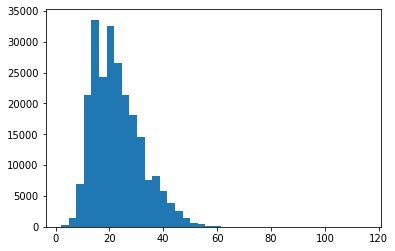

In [76]:
tokenizer_lengths = data["Joke"].map(lambda x: len(tokenizer.encode_plus(x)['input_ids']))
plt.hist(tokenizer_lengths, bins=40)
plt.show()

In [77]:
tokenizer_lengths.max()

115

In [78]:
tokenizer_lengths.min()

2

### Preparing data

In [6]:
class JokesDataset(Dataset):
    def __init__(self, jokes_filepath='data/shortjokes.csv'):
        data = pd.read_csv(jokes_filepath)
        self.jokes = data["Joke"].values
        
    def __len__(self):
        return len(self.jokes)
    
    def __getitem__(self, item):
        return self.jokes[item]

In [7]:
train_data = JokesDataset(jokes_filepath='data/shortjokes/train.csv')
test_data = JokesDataset(jokes_filepath='data/shortjokes/test.csv')
val_data = JokesDataset(jokes_filepath='data/shortjokes/val.csv')

In [8]:
def jokes_collate_fn(batch):
    batch_encoded = tokenizer.batch_encode_plus(
        batch,
        padding='max_length',
        return_tensors='pt',
        max_length=128
    )
    input_ids = batch_encoded['input_ids'].to(device)
    attention_mask = batch_encoded['attention_mask'].to(device)
    labels = input_ids.masked_fill(input_ids == tokenizer.pad_token_id, -100)
    return (input_ids, attention_mask, labels)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=3, shuffle=True, collate_fn=jokes_collate_fn)
val_dataloader = DataLoader(val_data, batch_size=3, collate_fn=jokes_collate_fn)

In [10]:
from tqdm.notebook import tqdm

def generate_sentences(model, tokenizer, num_return_sequences=250, max_length=None, return_tensors=True, promt=""):
    generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
    return generator(
        promt, 
        return_tensors=return_tensors, 
        num_return_sequences=num_return_sequences, 
        max_length=max_length
    )

# def calculate_perplexity(model):
#     max_length = model.config.n_positions
#     stride = 512

#     lls = []
#     for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
#         begin_loc = max(i + stride - max_length, 0)
#         end_loc = min(i + stride, encodings.input_ids.size(1))
#         trg_len = end_loc - i    # may be different from stride on last loop
#         input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
#         target_ids = input_ids.clone()
#         target_ids[:,:-trg_len] = -100

#         with torch.no_grad():
#             outputs = model(input_ids, labels=target_ids)
#             log_likelihood = outputs[0] * trg_len

#         lls.append(log_likelihood)

#     ppl = torch.exp(torch.stack(lls).sum() / end_loc)
    
#     return ppl

# def topological_loss(model, attentions):
#     pass

def train_model(
        model, 
        tokenizer, 
        train_dataloader, 
        val_dataloader=None,
        epochs=30, 
        logging="logs/jokes/default_with_labels", 
        optimizer=None,
        use_labels=False,
        toploss=False):
    """
    Train model without topological loss.
    
    logging: directory for logging results
    """
    if logging is not None:
        writer = SummaryWriter(log_dir=logging)
    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=3e-5)
        
    for epoch in tqdm(range(epochs), desc="Training on epoch"):
        model.train()
        for i, batch in enumerate(train_dataloader):
            input_ids, attention_mask, labels = batch
            if not use_labels:
                labels = input_ids
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            optimizer.zero_grad()
            output.loss.backward()
            optimizer.step()
            
            writer.add_scalar("Train/loss", output.loss.cpu().item(), len(train_dataloader)*epoch + i)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch
                if not use_labels:
                    labels = input_ids
                output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += output.loss.cpu().item()
            writer.add_scalar("Val/loss", val_loss/len(val_dataloader), len(train_dataloader)*epoch + i)
    return model

In [1]:
%load_ext tensorboard
%tensorboard --logdir logs/ --port 8803

In [ ]:
directory = "logs/jokes/default_faster"
model = train_model(model, tokenizer, train_dataloader, val_dataloader, logging=directory, use_labels=False)
model.save_pretrained(directory + "/model_1epoch")

Training on epoch:   0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
count_parameters(model)

124.44M parameters


In [22]:
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
generator("", return_tensors=True, num_return_sequences=20, max_length=None)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_token_ids': [50256,
   2437,
   466,
   345,
   4822,
   262,
   1438,
   286,
   257,
   48157,
   30,
   5283,
   12911,
   13,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257],
  'generated_text': 'How do you spell the name of a nun? Virgin Money.'},
 {'generated_token_ids': [50256,
   2061,
   338,
   534,
   4004,
   4144,
   30,
   1400,
   30,
   3894,
   340,
   338,
   477,
   826,
   994,
   1541,
   13,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257,
   50257

In [25]:
for batch in train_dataloader:
    input_ids, attention_mask, labels = batch

In [29]:
labels.shape

torch.Size([3, 1024])

In [31]:
model.eval()
with torch.no_grad():
    output = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids, output_attentions=True)

In [44]:
attentions = torch.stack([tensor.to("cpu") for tensor in output.attentions], dim=1)

In [52]:
attentions[0, 9, 7]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.8735e-01, 1.2653e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.5199e-01, 1.4250e-02, 3.3761e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [9.8967e-01, 3.6835e-04, 7.1064e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.8961e-01, 3.6619e-04, 7.1050e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.0587e-01, 2.7619e-03, 6.2824e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [50]:
batch_encoded

{'input_ids': tensor([[15496,    11,  1312,   716, 22254,   346,    13, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 5

In [51]:
input_ids = batch_encoded['input_ids'].to(device)
attention_mask = batch_encoded['attention_mask'].to(device)
labels = input_ids.masked_fill(input_ids == tokenizer.pad_token_id, -100)

In [54]:
labels

tensor([[15496,    11,  1312,   716, 22254,   346,    13,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [52]:
output = model(
    input_ids=input_ids, 
    attention_mask=attention_mask,
    output_attentions=True, 
    labels=labels
)

In [53]:
output.loss

tensor(87.8255, device='cuda:1', grad_fn=<NllLossBackward>)